## Εισαγωγικά

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn 
import scipy.stats

In [2]:
# Set random seed for reproducibility
import random
import os
SEED = 56
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

from sklearn.utils import check_random_state
check_random_state(SEED)

RandomState(MT19937) at 0x272727D2640

In [3]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


## Β. Προεπεξεργασία και Εξερεύνηση Δεδομένων

### 1. Εξερευνητική Ανάλυση Δεδομένων (EDA)

In [4]:
# Load data with pickling enabled
data = np.load(r'C:\\Users\\vasgk\\Desktop\\Μηχανική μάθηση\\Data\\breastmnist_224.npz', allow_pickle=True)

# Inspect the keys in the dataset
print("Keys in the dataset:", data.files)
print("Shape of file contents: (no of contents, dimensions (224x224))")

# Print the shape of each file in the original npz file
for key in data.files:
    print(f"{key}: {data[key].shape}")

Keys in the dataset: ['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']
Shape of file contents: (no of contents, dimensions (224x224))
train_images: (546, 224, 224)
train_labels: (546, 1)
val_images: (78, 224, 224)
val_labels: (78, 1)
test_images: (156, 224, 224)
test_labels: (156, 1)


In [ ]:
# Convert the data into a DataFrame
# Flatten the images and combine them with labels
# Flatten the images and combine them with labels
train_images_flat = data['train_images'].reshape(len(data['train_images']), -1)  # Flatten 224x224 images
df_train = pd.DataFrame(train_images_flat)
df_train['Label'] = data['train_labels']

# Repeat for validation and test data, but in reverse order because the dataset's ratio is reversed
val_images_flat = data['test_images'].reshape(len(data['test_images']), -1)
df_val = pd.DataFrame(val_images_flat)
df_val['Label'] = data['test_labels']

test_images_flat = data['val_images'].reshape(len(data['val_images']), -1)
df_test = pd.DataFrame(test_images_flat)
df_test['Label'] = data['val_labels']

# Split the data into features and labels for the rest of the code
x_train = df_train.drop(columns=['Label']).values  
y_train = df_train['Label'].values.ravel()  
x_val = df_val.drop(columns=['Label']).values 
y_val = df_val['Label'].values.ravel()  
x_test = df_test.drop(columns=['Label']).values  
y_test = df_test['Label'].values.ravel()  

## Ε. Βαθιά Νευρωνικά Δίκτυα

### CNN


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Μετατροπή ετικετών σε αριθμούς
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Βεβαιωθείτε ότι τα x_train, x_val, x_test έχουν σχήμα [num_samples, height, width]
# Αν έχουν σχήμα [num_samples, features], μετατρέψτε τα σε εικόνες (π.χ. 224x224 ή 128x128 ή 64x64)
# Εδώ υποθέτουμε ότι height και width είναι γνωστά, π.χ. 224
height = width = int(np.sqrt(x_train.shape[1])) if len(x_train.shape) == 2 else x_train.shape[1]

if len(x_train.shape) == 2:
    X_train_tensor = torch.tensor(x_train.reshape(-1, height, width), dtype=torch.float32).unsqueeze(1)
    X_val_tensor = torch.tensor(x_val.reshape(-1, height, width), dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(x_test.reshape(-1, height, width), dtype=torch.float32).unsqueeze(1)
else:
    X_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
    X_val_tensor = torch.tensor(x_val, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)

# Δημιουργία TensorDataset και DataLoader
train_data = TensorDataset(X_train_tensor, torch.tensor(y_train_encoded, dtype=torch.long))
val_data = TensorDataset(X_val_tensor, torch.tensor(y_val_encoded, dtype=torch.long))
test_data = TensorDataset(X_test_tensor, torch.tensor(y_test_encoded, dtype=torch.long))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Ορισμός του CNN μοντέλου
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 1: κανάλι εικόνας (grayscale)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)

        # Dynamically compute the size after conv/pool layers
        with torch.no_grad():
            dummy = torch.zeros(1, 1, height, width)
            x = self.relu(self.conv1(dummy))
            x = self.maxpool(x)
            x = self.relu(self.conv2(x))
            x = self.maxpool(x)
            x = self.relu(self.conv3(x))
            x = self.maxpool(x)
            flat_features = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flat_features, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten το tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Ορισμός του μοντέλου, κριτηρίου και optimizer
model = CNN(num_classes=len(np.unique(y_train)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Εκπαίδευση του μοντέλου
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

# Αξιολόγηση του μοντέλου στο Validation Set
model.eval()
val_correct = 0
val_total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_accuracy = 100 * val_correct / val_total
print(f"Validation Accuracy: {val_accuracy:.2f}%")

# Αξιολόγηση του μοντέλου στο Test Set
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Epoch 1/10, Loss: 84.1731, Accuracy: 60.99%
Epoch 2/10, Loss: 0.5868, Accuracy: 73.08%
Epoch 3/10, Loss: 0.5474, Accuracy: 74.91%
Epoch 4/10, Loss: 0.5840, Accuracy: 74.91%
Epoch 5/10, Loss: 0.4870, Accuracy: 76.92%
Epoch 6/10, Loss: 0.3489, Accuracy: 84.43%
Epoch 7/10, Loss: 0.2970, Accuracy: 87.00%
Epoch 8/10, Loss: 0.3699, Accuracy: 82.05%
Epoch 9/10, Loss: 0.3108, Accuracy: 86.45%
Epoch 10/10, Loss: 0.2869, Accuracy: 90.29%
Validation Accuracy: 62.82%
Test Accuracy: 67.95%



Training with lr=0.001, activation_fn=ReLU, weight_decay=0.01
Epoch 1/20, Train Loss: 54.9026, Train Accuracy: 62.27%, Val Loss: 0.5339, Val Accuracy: 73.08%
Epoch 2/20, Train Loss: 0.6999, Train Accuracy: 71.06%, Val Loss: 0.5452, Val Accuracy: 73.08%
Epoch 3/20, Train Loss: 0.5046, Train Accuracy: 72.89%, Val Loss: 0.5231, Val Accuracy: 72.44%
Epoch 4/20, Train Loss: 0.4222, Train Accuracy: 79.85%, Val Loss: 0.5396, Val Accuracy: 70.51%
Epoch 5/20, Train Loss: 0.3675, Train Accuracy: 81.87%, Val Loss: 0.5628, Val Accuracy: 71.15%
Epoch 6/20, Train Loss: 0.3682, Train Accuracy: 82.23%, Val Loss: 0.6399, Val Accuracy: 73.08%
Epoch 7/20, Train Loss: 0.2231, Train Accuracy: 89.38%, Val Loss: 0.6560, Val Accuracy: 70.51%
Epoch 8/20, Train Loss: 0.1900, Train Accuracy: 93.41%, Val Loss: 0.7046, Val Accuracy: 69.23%
Epoch 9/20, Train Loss: 0.2378, Train Accuracy: 90.48%, Val Loss: 0.7435, Val Accuracy: 76.92%
Epoch 10/20, Train Loss: 0.1896, Train Accuracy: 94.14%, Val Loss: 1.1938, Val Ac

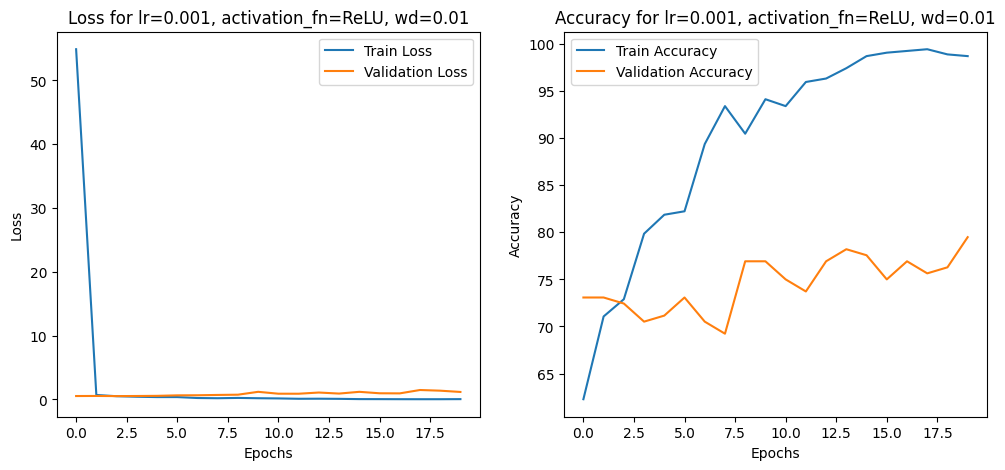


Training with lr=0.001, activation_fn=ReLU, weight_decay=0.001
Epoch 1/20, Train Loss: 85.7273, Train Accuracy: 62.64%, Val Loss: 0.8873, Val Accuracy: 73.08%
Epoch 2/20, Train Loss: 0.6360, Train Accuracy: 73.99%, Val Loss: 0.5398, Val Accuracy: 73.08%
Epoch 3/20, Train Loss: 0.5920, Train Accuracy: 74.73%, Val Loss: 0.5692, Val Accuracy: 73.72%
Epoch 4/20, Train Loss: 0.4925, Train Accuracy: 78.21%, Val Loss: 0.4842, Val Accuracy: 75.00%
Epoch 5/20, Train Loss: 0.3612, Train Accuracy: 82.97%, Val Loss: 0.5045, Val Accuracy: 73.72%
Epoch 6/20, Train Loss: 0.3250, Train Accuracy: 86.45%, Val Loss: 0.5323, Val Accuracy: 71.79%
Epoch 7/20, Train Loss: 0.2978, Train Accuracy: 88.46%, Val Loss: 0.6875, Val Accuracy: 73.72%
Epoch 8/20, Train Loss: 0.2634, Train Accuracy: 89.74%, Val Loss: 0.6374, Val Accuracy: 73.72%
Epoch 9/20, Train Loss: 0.2334, Train Accuracy: 90.66%, Val Loss: 0.8897, Val Accuracy: 75.00%
Epoch 10/20, Train Loss: 0.2501, Train Accuracy: 89.93%, Val Loss: 0.6186, Val A

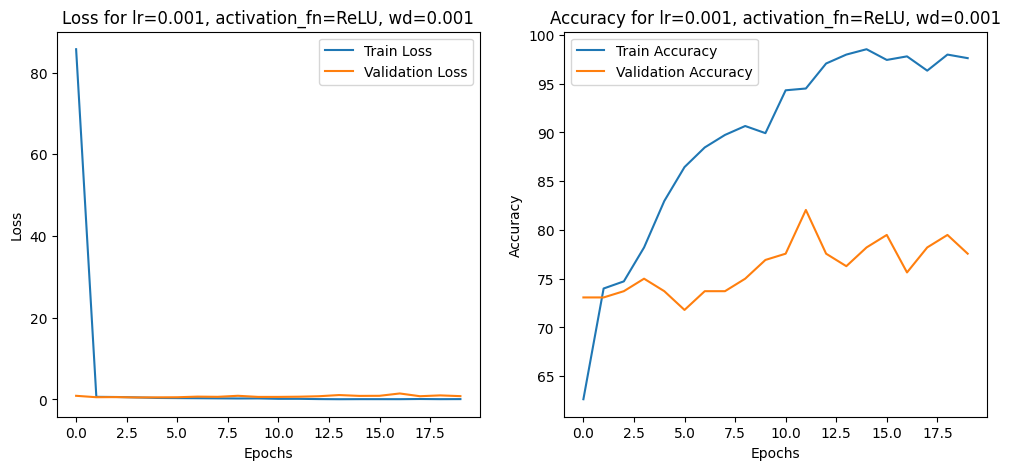


Training with lr=0.001, activation_fn=LeakyReLU, weight_decay=0.01
Epoch 1/20, Train Loss: 200.1347, Train Accuracy: 57.69%, Val Loss: 2.2639, Val Accuracy: 75.00%
Epoch 2/20, Train Loss: 4.7181, Train Accuracy: 68.13%, Val Loss: 12.0113, Val Accuracy: 30.13%
Epoch 3/20, Train Loss: 7.1526, Train Accuracy: 64.29%, Val Loss: 4.4580, Val Accuracy: 73.72%
Epoch 4/20, Train Loss: 3.7575, Train Accuracy: 67.03%, Val Loss: 2.5587, Val Accuracy: 73.72%
Epoch 5/20, Train Loss: 1.5387, Train Accuracy: 70.51%, Val Loss: 0.5283, Val Accuracy: 82.05%
Epoch 6/20, Train Loss: 1.1540, Train Accuracy: 71.98%, Val Loss: 1.4452, Val Accuracy: 75.64%
Epoch 7/20, Train Loss: 1.1484, Train Accuracy: 74.54%, Val Loss: 0.4656, Val Accuracy: 81.41%
Epoch 8/20, Train Loss: 0.8279, Train Accuracy: 73.08%, Val Loss: 0.4228, Val Accuracy: 83.33%
Epoch 9/20, Train Loss: 0.5215, Train Accuracy: 77.29%, Val Loss: 0.4061, Val Accuracy: 86.54%
Epoch 10/20, Train Loss: 0.4319, Train Accuracy: 79.49%, Val Loss: 0.3904,

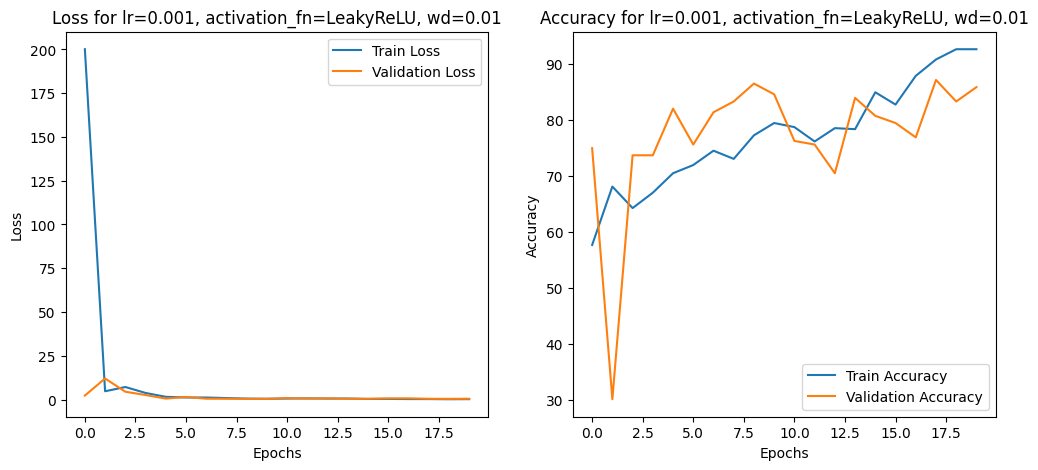


Training with lr=0.001, activation_fn=LeakyReLU, weight_decay=0.001
Epoch 1/20, Train Loss: 104.7887, Train Accuracy: 60.81%, Val Loss: 6.7391, Val Accuracy: 73.08%
Epoch 2/20, Train Loss: 3.6515, Train Accuracy: 67.22%, Val Loss: 1.8224, Val Accuracy: 76.92%
Epoch 3/20, Train Loss: 1.6600, Train Accuracy: 68.50%, Val Loss: 0.5271, Val Accuracy: 81.41%
Epoch 4/20, Train Loss: 0.8646, Train Accuracy: 70.15%, Val Loss: 0.4326, Val Accuracy: 82.69%
Epoch 5/20, Train Loss: 0.7337, Train Accuracy: 74.73%, Val Loss: 0.4795, Val Accuracy: 82.05%
Epoch 6/20, Train Loss: 1.1571, Train Accuracy: 73.26%, Val Loss: 1.0655, Val Accuracy: 75.00%
Epoch 7/20, Train Loss: 0.7506, Train Accuracy: 76.92%, Val Loss: 1.9463, Val Accuracy: 39.10%
Epoch 8/20, Train Loss: 1.1373, Train Accuracy: 67.77%, Val Loss: 0.5720, Val Accuracy: 81.41%
Epoch 9/20, Train Loss: 0.6039, Train Accuracy: 78.57%, Val Loss: 1.4223, Val Accuracy: 45.51%
Epoch 10/20, Train Loss: 0.9046, Train Accuracy: 73.81%, Val Loss: 0.5330,

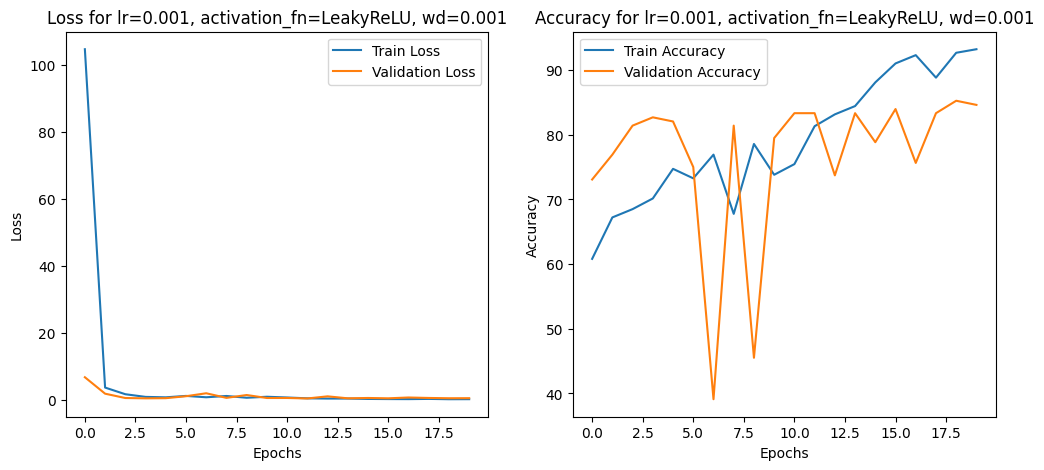


Training with lr=0.001, activation_fn=ELU, weight_decay=0.01
Epoch 1/20, Train Loss: 77.3770, Train Accuracy: 59.71%, Val Loss: 17.8317, Val Accuracy: 73.08%
Epoch 2/20, Train Loss: 23.2665, Train Accuracy: 63.37%, Val Loss: 8.0307, Val Accuracy: 75.64%
Epoch 3/20, Train Loss: 5.0223, Train Accuracy: 65.75%, Val Loss: 0.5851, Val Accuracy: 78.85%
Epoch 4/20, Train Loss: 0.8707, Train Accuracy: 69.60%, Val Loss: 0.5794, Val Accuracy: 67.95%
Epoch 5/20, Train Loss: 0.7588, Train Accuracy: 63.55%, Val Loss: 0.6587, Val Accuracy: 74.36%
Epoch 6/20, Train Loss: 0.7173, Train Accuracy: 65.57%, Val Loss: 0.5108, Val Accuracy: 75.64%
Epoch 7/20, Train Loss: 0.6718, Train Accuracy: 67.40%, Val Loss: 0.4931, Val Accuracy: 76.28%
Epoch 8/20, Train Loss: 0.6757, Train Accuracy: 68.68%, Val Loss: 0.5428, Val Accuracy: 75.00%
Epoch 9/20, Train Loss: 0.6211, Train Accuracy: 68.50%, Val Loss: 0.5112, Val Accuracy: 79.49%
Epoch 10/20, Train Loss: 0.6314, Train Accuracy: 69.78%, Val Loss: 0.4832, Val A

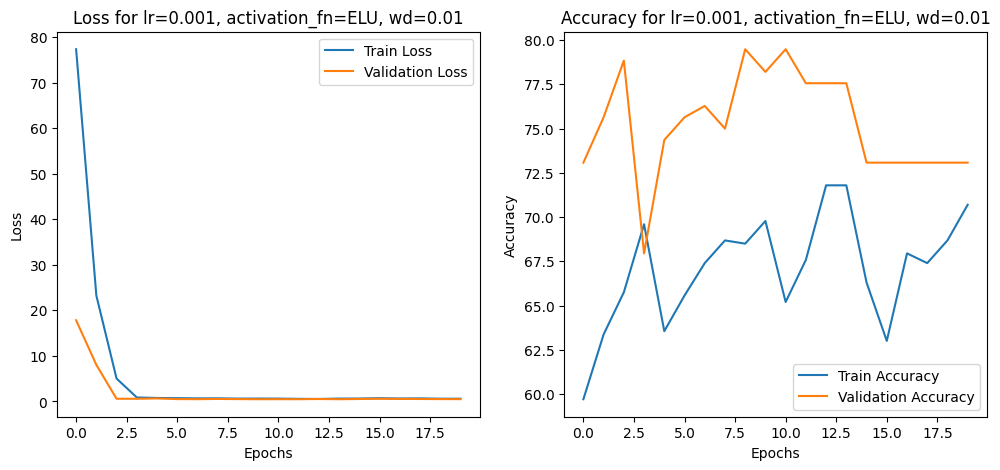


Training with lr=0.001, activation_fn=ELU, weight_decay=0.001
Epoch 1/20, Train Loss: 104.8588, Train Accuracy: 61.90%, Val Loss: 10.9176, Val Accuracy: 73.72%
Epoch 2/20, Train Loss: 3.2366, Train Accuracy: 61.54%, Val Loss: 0.6236, Val Accuracy: 74.36%
Epoch 3/20, Train Loss: 0.7917, Train Accuracy: 69.05%, Val Loss: 0.6829, Val Accuracy: 73.08%
Epoch 4/20, Train Loss: 0.6942, Train Accuracy: 67.22%, Val Loss: 0.6064, Val Accuracy: 73.08%
Epoch 5/20, Train Loss: 0.6359, Train Accuracy: 63.92%, Val Loss: 0.5855, Val Accuracy: 73.08%
Epoch 6/20, Train Loss: 0.6354, Train Accuracy: 70.88%, Val Loss: 0.5716, Val Accuracy: 73.08%
Epoch 7/20, Train Loss: 0.5849, Train Accuracy: 71.06%, Val Loss: 0.5572, Val Accuracy: 73.08%
Epoch 8/20, Train Loss: 0.6162, Train Accuracy: 72.71%, Val Loss: 0.5560, Val Accuracy: 73.08%
Epoch 9/20, Train Loss: 0.5642, Train Accuracy: 71.61%, Val Loss: 0.5452, Val Accuracy: 73.08%
Epoch 10/20, Train Loss: 0.5921, Train Accuracy: 70.51%, Val Loss: 0.5510, Val 

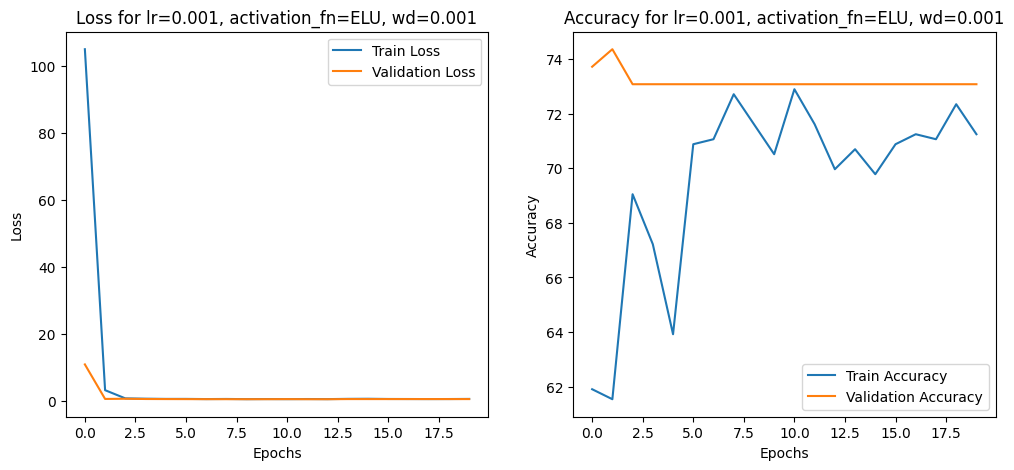


Training with lr=0.0001, activation_fn=ReLU, weight_decay=0.01
Epoch 1/20, Train Loss: 11.0196, Train Accuracy: 63.19%, Val Loss: 1.8861, Val Accuracy: 73.72%
Epoch 2/20, Train Loss: 0.7795, Train Accuracy: 70.33%, Val Loss: 0.4788, Val Accuracy: 73.08%
Epoch 3/20, Train Loss: 0.4105, Train Accuracy: 78.75%, Val Loss: 0.4126, Val Accuracy: 80.77%
Epoch 4/20, Train Loss: 0.3348, Train Accuracy: 89.01%, Val Loss: 0.3809, Val Accuracy: 85.26%
Epoch 5/20, Train Loss: 0.2240, Train Accuracy: 92.31%, Val Loss: 0.4261, Val Accuracy: 80.77%
Epoch 6/20, Train Loss: 0.1536, Train Accuracy: 95.60%, Val Loss: 0.4099, Val Accuracy: 82.05%
Epoch 7/20, Train Loss: 0.0917, Train Accuracy: 97.44%, Val Loss: 0.4506, Val Accuracy: 82.05%
Epoch 8/20, Train Loss: 0.0787, Train Accuracy: 97.62%, Val Loss: 0.4399, Val Accuracy: 85.26%
Epoch 9/20, Train Loss: 0.0477, Train Accuracy: 99.82%, Val Loss: 0.5466, Val Accuracy: 83.33%
Epoch 10/20, Train Loss: 0.0272, Train Accuracy: 99.63%, Val Loss: 0.5905, Val A

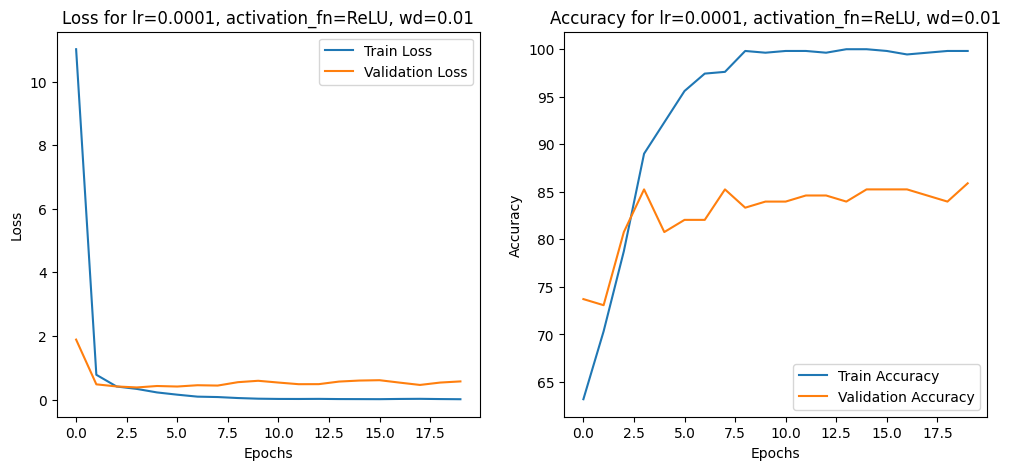


Training with lr=0.0001, activation_fn=ReLU, weight_decay=0.001
Epoch 1/20, Train Loss: 10.5626, Train Accuracy: 62.45%, Val Loss: 1.1373, Val Accuracy: 75.00%
Epoch 2/20, Train Loss: 1.0717, Train Accuracy: 71.61%, Val Loss: 0.4937, Val Accuracy: 75.00%
Epoch 3/20, Train Loss: 0.4730, Train Accuracy: 76.92%, Val Loss: 0.4754, Val Accuracy: 83.97%
Epoch 4/20, Train Loss: 0.3719, Train Accuracy: 83.70%, Val Loss: 0.4159, Val Accuracy: 80.13%
Epoch 5/20, Train Loss: 0.2780, Train Accuracy: 88.46%, Val Loss: 0.4206, Val Accuracy: 81.41%
Epoch 6/20, Train Loss: 0.2179, Train Accuracy: 90.11%, Val Loss: 0.3992, Val Accuracy: 82.69%
Epoch 7/20, Train Loss: 0.1379, Train Accuracy: 94.14%, Val Loss: 0.4536, Val Accuracy: 83.33%
Epoch 8/20, Train Loss: 0.0822, Train Accuracy: 98.35%, Val Loss: 0.3878, Val Accuracy: 86.54%
Epoch 9/20, Train Loss: 0.0607, Train Accuracy: 99.08%, Val Loss: 0.4036, Val Accuracy: 87.18%
Epoch 10/20, Train Loss: 0.0455, Train Accuracy: 99.45%, Val Loss: 0.5509, Val 

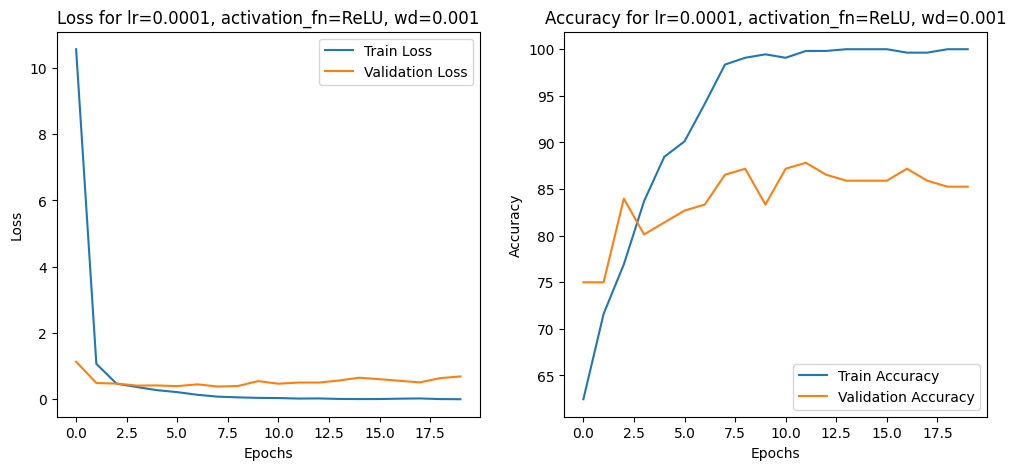


Training with lr=0.0001, activation_fn=LeakyReLU, weight_decay=0.01
Epoch 1/20, Train Loss: 15.9453, Train Accuracy: 61.36%, Val Loss: 0.8405, Val Accuracy: 79.49%
Epoch 2/20, Train Loss: 1.1165, Train Accuracy: 71.79%, Val Loss: 0.7517, Val Accuracy: 73.72%
Epoch 3/20, Train Loss: 0.4224, Train Accuracy: 79.67%, Val Loss: 0.3942, Val Accuracy: 83.33%
Epoch 4/20, Train Loss: 0.3107, Train Accuracy: 85.53%, Val Loss: 0.4305, Val Accuracy: 80.13%
Epoch 5/20, Train Loss: 0.2303, Train Accuracy: 88.83%, Val Loss: 0.4608, Val Accuracy: 83.33%
Epoch 6/20, Train Loss: 0.1549, Train Accuracy: 93.96%, Val Loss: 0.4301, Val Accuracy: 83.97%
Epoch 7/20, Train Loss: 0.1471, Train Accuracy: 94.69%, Val Loss: 0.4802, Val Accuracy: 84.62%
Epoch 8/20, Train Loss: 0.1286, Train Accuracy: 95.97%, Val Loss: 0.5433, Val Accuracy: 85.26%
Epoch 9/20, Train Loss: 0.0612, Train Accuracy: 97.99%, Val Loss: 0.6209, Val Accuracy: 83.97%
Epoch 10/20, Train Loss: 0.0476, Train Accuracy: 97.99%, Val Loss: 0.5257, 

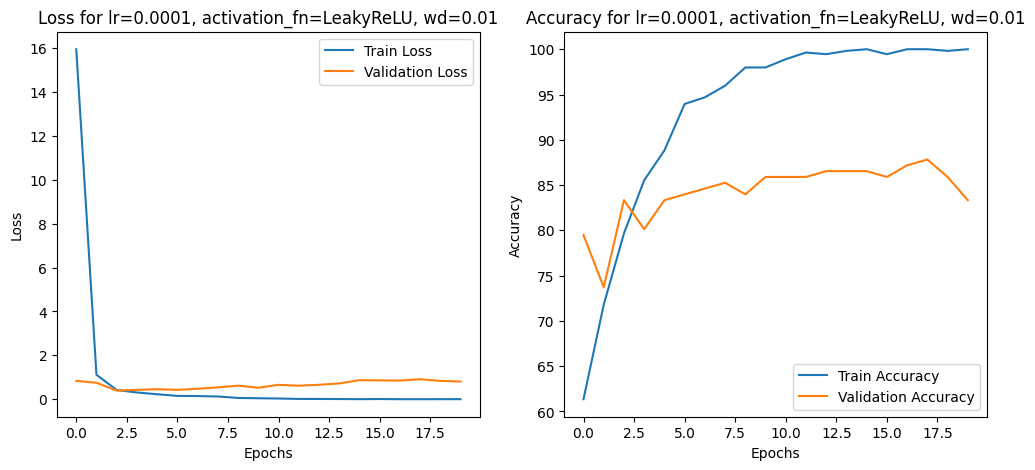


Training with lr=0.0001, activation_fn=LeakyReLU, weight_decay=0.001
Epoch 1/20, Train Loss: 17.3769, Train Accuracy: 64.10%, Val Loss: 5.3984, Val Accuracy: 73.08%
Epoch 2/20, Train Loss: 1.4664, Train Accuracy: 73.26%, Val Loss: 0.5746, Val Accuracy: 69.87%
Epoch 3/20, Train Loss: 0.4667, Train Accuracy: 80.77%, Val Loss: 0.4339, Val Accuracy: 83.97%
Epoch 4/20, Train Loss: 0.3441, Train Accuracy: 83.70%, Val Loss: 0.4143, Val Accuracy: 83.97%
Epoch 5/20, Train Loss: 0.2232, Train Accuracy: 91.58%, Val Loss: 0.4013, Val Accuracy: 86.54%
Epoch 6/20, Train Loss: 0.1460, Train Accuracy: 94.14%, Val Loss: 0.4278, Val Accuracy: 85.90%
Epoch 7/20, Train Loss: 0.0978, Train Accuracy: 96.89%, Val Loss: 0.5093, Val Accuracy: 85.90%
Epoch 8/20, Train Loss: 0.0505, Train Accuracy: 98.72%, Val Loss: 0.6035, Val Accuracy: 85.26%
Epoch 9/20, Train Loss: 0.0319, Train Accuracy: 99.63%, Val Loss: 0.6254, Val Accuracy: 86.54%
Epoch 10/20, Train Loss: 0.0316, Train Accuracy: 99.27%, Val Loss: 0.5799,

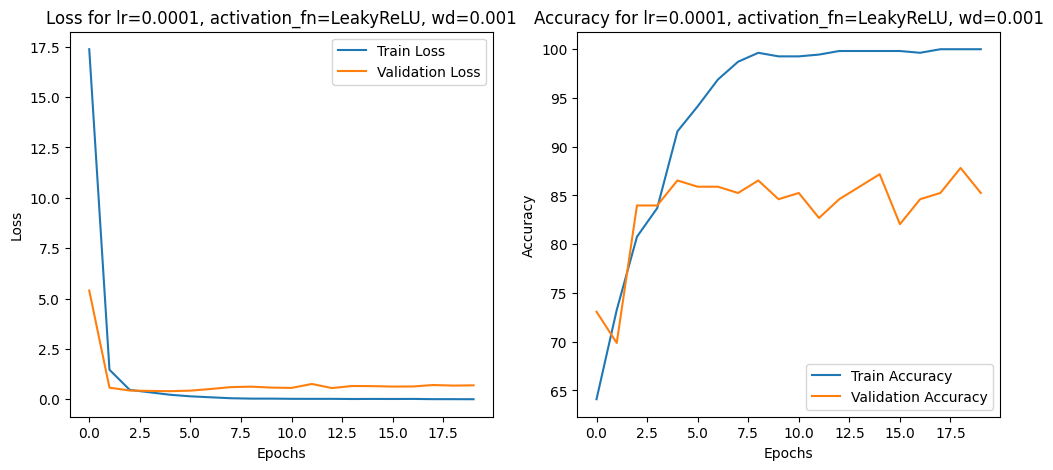


Training with lr=0.0001, activation_fn=ELU, weight_decay=0.01
Epoch 1/20, Train Loss: 10.7060, Train Accuracy: 59.34%, Val Loss: 1.4252, Val Accuracy: 73.08%
Epoch 2/20, Train Loss: 0.8166, Train Accuracy: 67.03%, Val Loss: 0.5511, Val Accuracy: 73.72%
Epoch 3/20, Train Loss: 0.5828, Train Accuracy: 73.08%, Val Loss: 0.5435, Val Accuracy: 79.49%
Epoch 4/20, Train Loss: 0.6042, Train Accuracy: 70.51%, Val Loss: 0.4439, Val Accuracy: 80.13%
Epoch 5/20, Train Loss: 0.4572, Train Accuracy: 77.47%, Val Loss: 0.4185, Val Accuracy: 81.41%
Epoch 6/20, Train Loss: 0.4199, Train Accuracy: 83.88%, Val Loss: 0.3778, Val Accuracy: 83.97%
Epoch 7/20, Train Loss: 0.3877, Train Accuracy: 82.78%, Val Loss: 0.4014, Val Accuracy: 81.41%
Epoch 8/20, Train Loss: 0.3472, Train Accuracy: 85.71%, Val Loss: 0.5406, Val Accuracy: 78.21%
Epoch 9/20, Train Loss: 0.3242, Train Accuracy: 86.81%, Val Loss: 0.3659, Val Accuracy: 87.18%
Epoch 10/20, Train Loss: 0.2898, Train Accuracy: 88.83%, Val Loss: 0.3672, Val Ac

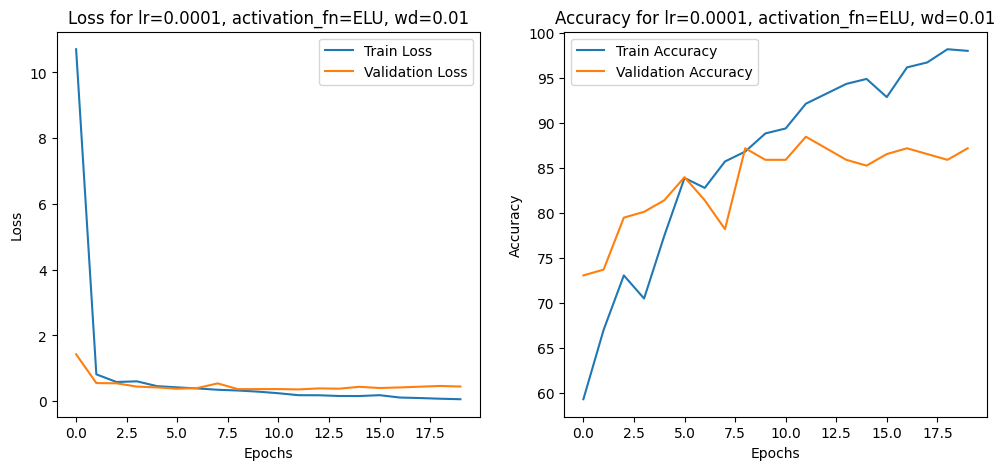


Training with lr=0.0001, activation_fn=ELU, weight_decay=0.001
Epoch 1/20, Train Loss: 14.0618, Train Accuracy: 62.45%, Val Loss: 1.7065, Val Accuracy: 73.08%
Epoch 2/20, Train Loss: 0.7199, Train Accuracy: 67.40%, Val Loss: 0.7359, Val Accuracy: 73.08%
Epoch 3/20, Train Loss: 0.6358, Train Accuracy: 68.13%, Val Loss: 0.5542, Val Accuracy: 73.08%
Epoch 4/20, Train Loss: 0.6249, Train Accuracy: 70.33%, Val Loss: 0.5304, Val Accuracy: 73.08%
Epoch 5/20, Train Loss: 0.5869, Train Accuracy: 70.88%, Val Loss: 0.5426, Val Accuracy: 73.08%
Epoch 6/20, Train Loss: 0.6088, Train Accuracy: 72.89%, Val Loss: 0.5304, Val Accuracy: 73.08%
Epoch 7/20, Train Loss: 0.5426, Train Accuracy: 72.16%, Val Loss: 0.5299, Val Accuracy: 73.08%
Epoch 8/20, Train Loss: 0.6501, Train Accuracy: 71.79%, Val Loss: 0.5049, Val Accuracy: 73.08%
Epoch 9/20, Train Loss: 0.7109, Train Accuracy: 60.81%, Val Loss: 0.5936, Val Accuracy: 73.08%
Epoch 10/20, Train Loss: 0.6176, Train Accuracy: 64.84%, Val Loss: 0.5691, Val A

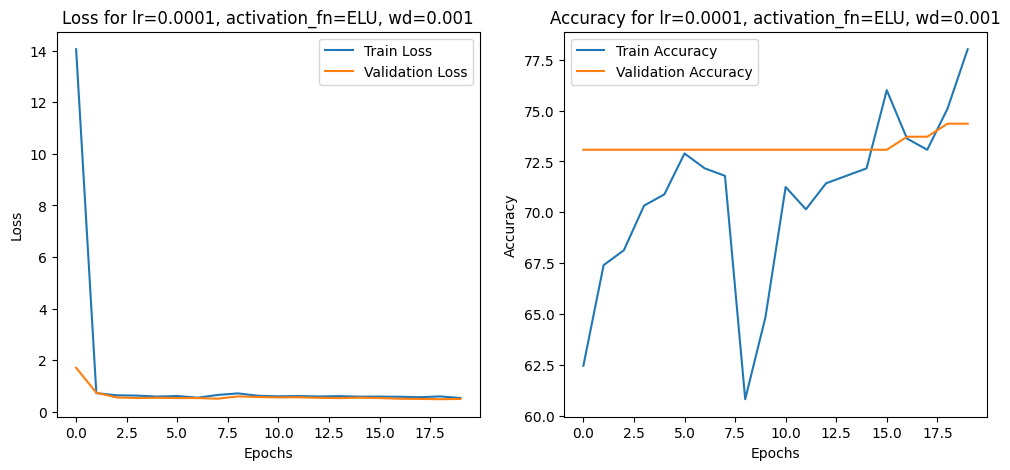

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Μετατροπή ετικετών σε αριθμούς
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Μετατροπή των εικόνων σε PyTorch tensors με σωστό shape [num_samples, 1, height, width]
height, width = 224, 224  # ή βάλτε το σωστό μέγεθος εικόνας αν είναι διαφορετικό
X_train_tensor = torch.tensor(x_train.reshape(-1, 1, height, width), dtype=torch.float32)
X_val_tensor = torch.tensor(x_val.reshape(-1, 1, height, width), dtype=torch.float32)
X_test_tensor = torch.tensor(x_test.reshape(-1, 1, height, width), dtype=torch.float32)

# Δημιουργία TensorDataset και DataLoader
train_data = TensorDataset(X_train_tensor, torch.tensor(y_train_encoded, dtype=torch.long))
val_data = TensorDataset(X_val_tensor, torch.tensor(y_val_encoded, dtype=torch.long))
test_data = TensorDataset(X_test_tensor, torch.tensor(y_test_encoded, dtype=torch.long))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Ορισμός του CNN μοντέλου με Dropout και διαφορετικές συναρτήσεις ενεργοποίησης
class CNN(nn.Module):
    def __init__(self, num_classes, activation_fn='ReLU'):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Προσαρμογή ανάλογα με το μέγεθος των εικόνων (224x224 -> 28x28)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)  # Dropout για κανονικοποίηση

        if activation_fn == 'ReLU':
            self.activation = nn.ReLU()
        elif activation_fn == 'LeakyReLU':
            self.activation = nn.LeakyReLU(0.1)
        elif activation_fn == 'ELU':
            self.activation = nn.ELU()
        else:
            raise ValueError(f"Unknown activation function: {activation_fn}")

        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.maxpool(x)
        x = self.activation(self.conv2(x))
        x = self.maxpool(x)
        x = self.activation(self.conv3(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten το tensor
        x = self.dropout(self.activation(self.fc1(x)))  # Dropout πριν από το πλήρως συνδεδεμένο επίπεδο
        x = self.fc2(x)
        return x

# Εφαρμογή Regularization μέσω L2 (Weight Decay) στον Adam optimizer
def create_model_and_optimizer(activation_fn='ReLU', lr=0.001, weight_decay=0.01):
    model = CNN(num_classes=len(np.unique(y_train)), activation_fn=activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    return model, criterion, optimizer

# Ορισμός της διαδικασίας εκπαίδευσης με αποθήκευση του καλύτερου μοντέλου
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []  
    
    best_val_accuracy = 0.0
    best_model_state_dict = None  # Για να αποθηκεύσουμε το state dict του καλύτερου μοντέλου

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Αξιολόγηση στο Validation Set
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

        # Αν η ακρίβεια στο validation set είναι καλύτερη, αποθηκεύουμε το μοντέλο
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state_dict = model.state_dict()  # Αποθήκευση του state_dict του καλύτερου μοντέλου

    # Αποθήκευση του καλύτερου μοντέλου στο τέλος της εκπαίδευσης
    if best_model_state_dict is not None:
        torch.save(best_model_state_dict, 'best_model.pth')  # Αποθήκευση του καλύτερου μοντέλου

    return train_losses, train_accuracies, val_losses, val_accuracies


# Ορισμός υπερπαραμέτρων για τον πειραματισμό
learning_rates = [0.001, 0.0001]
activation_functions = ['ReLU', 'LeakyReLU', 'ELU']
weight_decays = [0.01, 0.001]

# Πειραματισμός με διαφορετικούς συνδυασμούς
for lr in learning_rates:
    for activation_fn in activation_functions:
        for wd in weight_decays:
            print(f"\nTraining with lr={lr}, activation_fn={activation_fn}, weight_decay={wd}")
            model, criterion, optimizer = create_model_and_optimizer(activation_fn, lr, wd)
            train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader)

            # Οπτικοποίηση των καμπυλών μάθησης
            plt.figure(figsize=(12, 5))

            # Καμπύλες Απώλειας
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label='Train Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.title(f'Loss for lr={lr}, activation_fn={activation_fn}, wd={wd}')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()

            # Καμπύλες Ακρίβειας
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracies, label='Train Accuracy')
            plt.plot(val_accuracies, label='Validation Accuracy')
            plt.title(f'Accuracy for lr={lr}, activation_fn={activation_fn}, wd={wd}')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()

            plt.show()

Best Hyperparameters: {'learning_rate': 0.001, 'activation_fn': 'ReLU', 'weight_decay': 0.01}
Test Loss: 0.6806, Test Accuracy: 30.77%


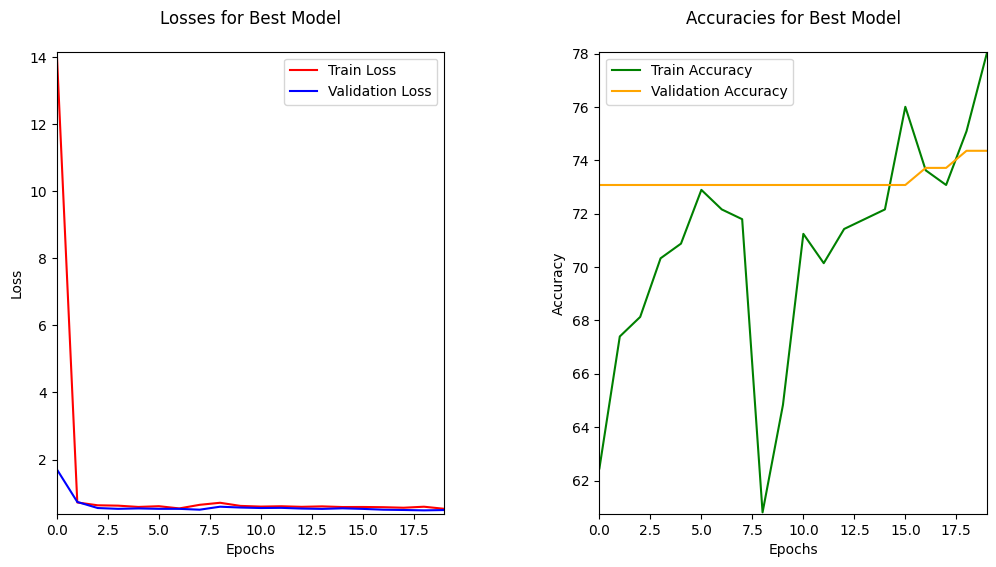

In [ ]:
# Φόρτωση του καλύτερου μοντέλου
best_model = CNN(num_classes=len(np.unique(y_train)), activation_fn='ReLU')  # Χρησιμοποιήστε τα ίδια χαρακτηριστικά του μοντέλου που είχατε πριν
best_model.load_state_dict(torch.load('best_model.pth'))  # Φορτώνουμε το state dict από το αρχείο

# Ορισμός του criterion
criterion = torch.nn.CrossEntropyLoss()

# Επαναφορά του μοντέλου σε "evaluation" mode
best_model.eval()

# Υπολογισμός του Test Loss και Test Accuracy (χωρίς να το εμφανίσουμε στα γραφήματα)
with torch.no_grad():
    test_outputs = best_model(X_test_tensor)  # Υπολογισμός εξόδου για το test set
    test_loss = criterion(test_outputs, torch.tensor(y_test_encoded, dtype=torch.long)).item()  # Υπολογισμός του Test Loss
    _, predicted = torch.max(test_outputs, 1)
    test_accuracy = (predicted == torch.tensor(y_test_encoded, dtype=torch.long)).sum().item() / len(y_test_encoded) * 100

# Εκτύπωση των βέλτιστων υπερπαραμέτρων
# Αν δεν έχετε μεταβλητή με τις βέλτιστες υπερπαραμέτρους, ορίστε την εδώ (π.χ. από το καλύτερο run)
# ΘΕΛΕΙ ΑΛΛΑΓΗ !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
best_hyperparameters = {
    'learning_rate': 0.001,
    'activation_fn': 'ReLU',
    'weight_decay': 0.01
}
print(f'Best Hyperparameters: {best_hyperparameters}')
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Αποθήκευση των αποτελεσμάτων στο best_result dictionary
best_result = {
    'train_losses': train_losses,  # Απώλειες για το train set κατά την εκπαίδευση
    'val_losses': val_losses,      # Απώλειες για το validation set κατά την εκπαίδευση
    'train_accuracies': train_accuracies,  # Ακρίβεια για το train set κατά την εκπαίδευση
    'val_accuracies': val_accuracies,      # Ακρίβεια για το validation set κατά την εκπαίδευση
}

# Οπτικοποίηση των αποτελεσμάτων χωρίς το Test Loss και Test Accuracy
plt.figure(figsize=(12, 6))

# Γράφημα για τις Απώλειες του καλύτερου μοντέλου
plt.subplot(1, 2, 1)
plt.plot(range(len(best_result['train_losses'])), best_result['train_losses'], label='Train Loss', color='red')
plt.plot(range(len(best_result['val_losses'])), best_result['val_losses'], label='Validation Loss', color='blue')
plt.title(f'Losses for Best Model', pad=20)  # Προσθήκη padding στον τίτλο
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Ορισμός του άξονα x ώστε να ξεκινά από το 0
plt.xlim(0, len(best_result['train_losses'])-1)
plt.ylim(min(train_losses + val_losses) - 0.1, max(train_losses + val_losses) + 0.1)

# Γράφημα για τις Ακρίβειες του καλύτερου μοντέλου
plt.subplot(1, 2, 2)
plt.plot(range(len(best_result['train_accuracies'])), best_result['train_accuracies'], label='Train Accuracy', color='green')
plt.plot(range(len(best_result['val_accuracies'])), best_result['val_accuracies'], label='Validation Accuracy', color='orange')
plt.title(f'Accuracies for Best Model', pad=20)  # Προσθήκη padding στον τίτλο
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Ορισμός του άξονα x ώστε να ξεκινά από το 0
plt.xlim(0, len(best_result['train_accuracies'])-1)
plt.ylim(min(train_accuracies + val_accuracies) - 0.05, max(train_accuracies + val_accuracies) + 0.05)

# Χρήση του `subplots_adjust` για να αυξήσεις την απόσταση μεταξύ των υποπλοτ
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.show()

Classification Report for Train Set:
              precision    recall  f1-score   support

           0       0.29      1.00      0.45       147
           1       1.00      0.10      0.17       399

    accuracy                           0.34       546
   macro avg       0.64      0.55      0.31       546
weighted avg       0.81      0.34      0.25       546



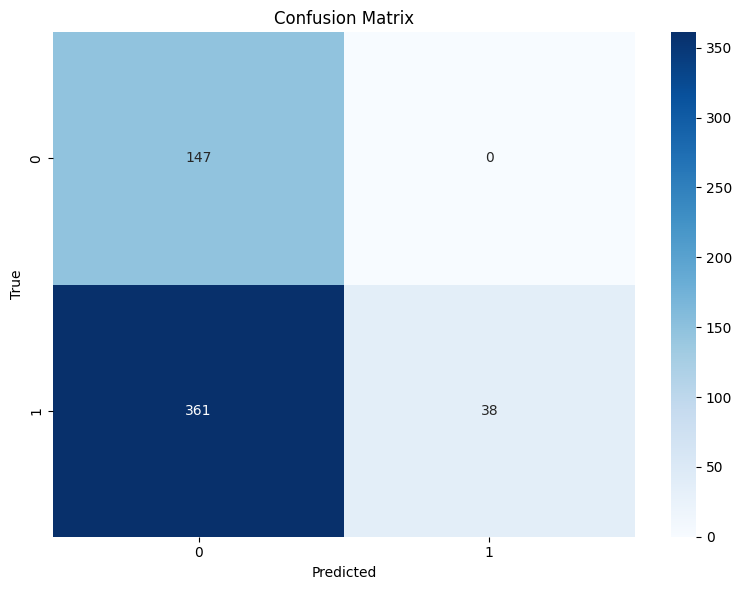

Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.29      0.98      0.45        42
           1       0.93      0.11      0.20       114

    accuracy                           0.35       156
   macro avg       0.61      0.55      0.32       156
weighted avg       0.76      0.35      0.27       156



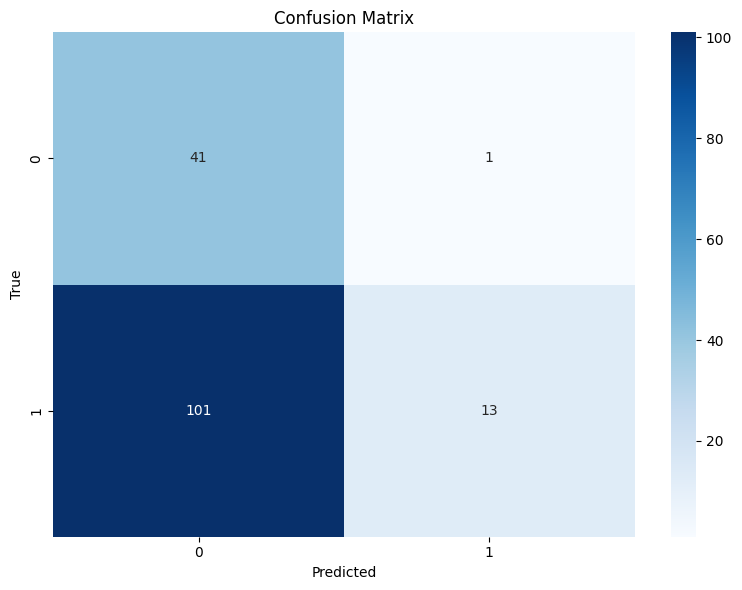

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.28      1.00      0.44        21
           1       1.00      0.05      0.10        57

    accuracy                           0.31        78
   macro avg       0.64      0.53      0.27        78
weighted avg       0.81      0.31      0.19        78



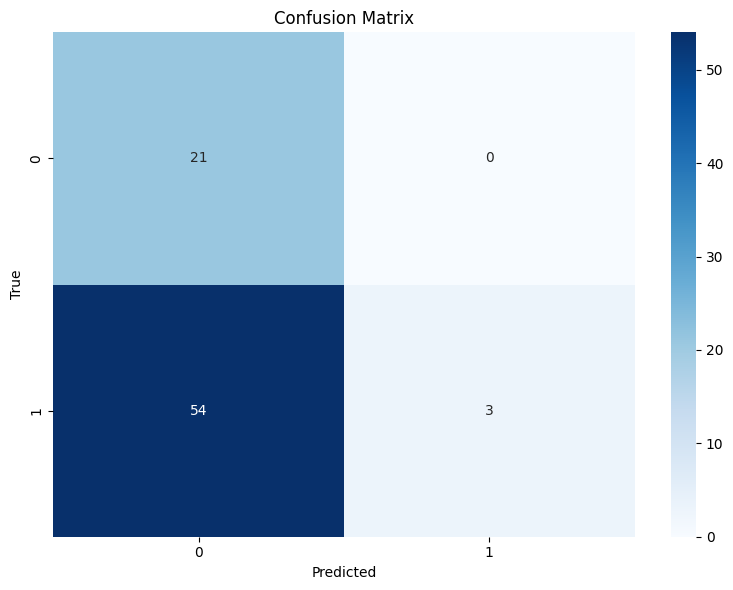

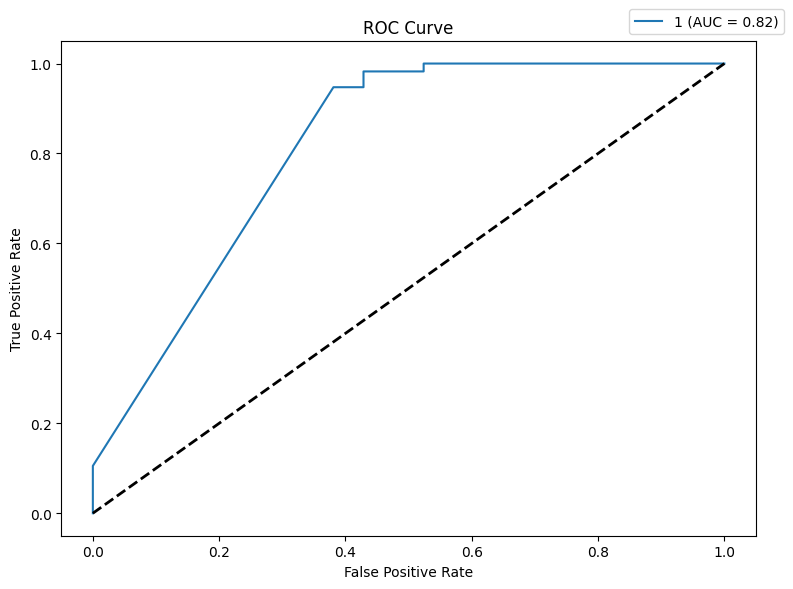

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize


# Μεταφορά του μοντέλου στην ίδια συσκευή
best_model.to(device)

# Συνάρτηση για την εκτύπωση του classification report και της confusion matrix
def evaluate_model(model, X_data_tensor, y_data_tensor, class_names, device):
    model.eval()  # Θέτουμε το μοντέλο σε κατάσταση αξιολόγησης
    with torch.no_grad():
        # Στείλε τα δεδομένα στην ίδια συσκευή με το μοντέλο
        X_data_tensor = X_data_tensor.to(device)
        y_data_tensor = y_data_tensor.to(device)

        # Υπολογισμός εξόδου
        outputs = model(X_data_tensor)
        _, predicted = torch.max(outputs, 1)

    # Μεταφορά των προβλέψεων και των αληθινών ετικετών στη CPU
    y_pred = predicted.cpu().numpy()
    y_true = y_data_tensor.cpu().numpy()

    # Εκτύπωση Classification Report
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Συνάρτηση για την δημιουργία της ROC Curve
def plot_roc_curve(model, X_test_tensor, y_test_encoded, class_names, device):
    # Binarize the true labels for ROC
    y_test_bin = label_binarize(y_test_encoded, classes=np.arange(len(class_names)))

    # Move data to device
    X_test_tensor = X_test_tensor.to(device)
    y_test_encoded = torch.tensor(y_test_encoded, dtype=torch.long).to(device)

    with torch.no_grad():
        outputs = model(X_test_tensor)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

    plt.figure(figsize=(8, 6))
    if len(class_names) == 2:
        # Binary classification: plot only one ROC curve (for class 1)
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), probs[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[1]} (AUC = {roc_auc:.2f})')
    else:
        # Multiclass case
        for i in range(len(class_names)):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

# Εκτίμηση του μοντέλου για train, val και test set
class_names = [str(c) for c in label_encoder.classes_]

# Αξιολόγηση στο Train Set
print("Classification Report for Train Set:")
evaluate_model(best_model, X_train_tensor, torch.tensor(y_train_encoded, dtype=torch.long), class_names, device)

# Αξιολόγηση στο Validation Set
print("Classification Report for Validation Set:")
evaluate_model(best_model, X_val_tensor, torch.tensor(y_val_encoded, dtype=torch.long), class_names, device)

# Αξιολόγηση στο Test Set
print("Classification Report for Test Set:")
evaluate_model(best_model, X_test_tensor, torch.tensor(y_test_encoded, dtype=torch.long), class_names, device)

# Εκτύπωση ROC Curve
plot_roc_curve(best_model, X_test_tensor, y_test_encoded, class_names, device)